Creating a custom CNN for detection of cancer from histology specimens.

##first imports for torch, torchvision, numpy, pandas, and os

In [ ]:
import torch
import torch
import torch.nn.functional as F
from torch import nn
from torch import optim
from torchvision import datasets, transforms, models
from torch.utils.data.sampler import SubsetRandomSampler

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import PIL
import matplotlib as plt

In [2]:
import os
import pandas as pd
import numpy as np
import shutil

In [3]:
#Set up for cuda usage
device = torch.device("cuda" if torch.cuda.is_available else "cpu")
print("{} is available".format(device))

cuda is available


Below I seprate the training set into sperate train and validation folders -- I left it up to the user to place directories and creat the 0 and 1 subfolders because of different 

In [ ]:
# Reorganizing data to subfolders zero and one for pytorch labels implementation as well as seperate into valid folders sperately 
# to seperate image augmentation transforms and validation transforms

labels = pd.read_csv(r'''C:\Users\gtm12\OneDrive\Documents\Jupyter Notebooks\Kaggle\Histo_cancer\train_labels.csv''')

training_path = r'''C:\Users\gtm12\OneDrive\Documents\Jupyter Notebooks\Kaggle\Histo_cancer\histo_data\train\\'''
train_path_0 = r'''C:\Users\gtm12\OneDrive\Documents\Jupyter Notebooks\Kaggle\Histo_cancer\histo_data\train\0\\'''
train_path_1 = r'''C:\Users\gtm12\OneDrive\Documents\Jupyter Notebooks\Kaggle\Histo_cancer\histo_data\train\1\\'''
valid_path_0 = r'''C:\Users\gtm12\OneDrive\Documents\Jupyter Notebooks\Kaggle\Histo_cancer\histo_data\valid\0\\'''
valid_path_1 = r'''C:\Users\gtm12\OneDrive\Documents\Jupyter Notebooks\Kaggle\Histo_cancer\histo_data\valid\1\\'''

percent_valid = .15


def file_valid_split_copy_delete(training_path, train_path_0, train_path_1, valid_path_0, valid_path_1, percent_valid)
    counter_0 = 0
    counter_1 = 0

    for i in range(len(labels)):
        if labels.label[i] == 0:
            counter_false +=1
        if labels.label[i] == 1:
            counter_true +=1

    train_split_0 = int(percent_valid * counter_false)
    train_split_1 = int(percent_valid * counter_true)

    for i in range(len(labels)):
        file_name = str(labels.id[i]) + '.tif'
        if labels.label[i].item() == 0:
            if counter_0 <= train_split_0:
                file_path_copy = valid_path_0
                counter_0 += 1
                file_origin = training_path + file_name
                file_path_copy = file_path_copy + file_name
                shutil.copy2(file_origin, file_path_copy)
                os.remove(file_origin)
            else:
                file_path_copy = train_path_0
                counter_0 += 1
                file_origin = training_path + file_name
                file_path_copy = file_path_copy + file_name
                shutil.copy2(file_origin, file_path_copy)
                os.remove(file_origin)

        elif labels.label[i].item() == 1:
            if counter_1 <= trains_split_1:
                file_path_copy = valid_path_1
                counter_1 += 1
                file_origin = training_path + file_name
                file_path_copy = file_path_copy + file_name
                shutil.copy2(file_origin, file_path_copy)
                os.remove(file_origin)
            else:
                file_path_copy = train_path_1
                counter_0 += 1
                file_origin = training_path + file_name
                file_path_copy = file_path_copy + file_name
                shutil.copy2(file_origin, file_path_copy)
                os.remove(file_origin)
                
    print("files have been relocated")
    
    return

In [ ]:
file_valid_split_copy_delete(training_path, train_path_0, train_path_1, valid_path_0, valid_path_1, percent_valid)

In [ ]:
# Begin to load Data Transforms and split validation set

In [4]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 1000
# percentage of training set to use as validation
valid_size = 0.15
#file directories
data_dir =  r'''C:\Users\gtm12\OneDrive\Documents\Jupyter Notebooks\Kaggle\Histo_cancer\histo_data\\'''
train_dir = data_dir + 'train\\'
valid_dir = data_dir + 'valid\\'
test_dir = data_dir + 'test\\'

In [11]:
# TODO: Define your transforms for the training and validation sets
train_transforms = transforms.Compose([transforms.RandomRotation(15),
                                      transforms.RandomResizedCrop(32),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ColorJitter(brightness=0.4,
                                                             contrast=0.4,
                                                             saturation = 0.4,
                                                             hue=0.1),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                          [0.229, 0.224, 0.225])])

valid_transforms = transforms.Compose([transforms.Resize(48),
                                      transforms.CenterCrop(32),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                          [0.229, 0.224, 0.225])])

#test_transforms = transforms.Compose([transforms.CenterCrop(32),
#                                      transforms.ToTensor(),
#                                      transforms.Normalize([0.485, 0.456, 0.406],
#                                                          [0.229, 0.224, 0.225])])



# TODO: Load the datasets with ImageFolder
train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
valid_data = datasets.ImageFolder(valid_dir, transform=valid_transforms)
#test_data = datasets.ImageFolder(test_dir, transform=test_transforms)


# TODO: Using the image datasets and the trainforms, define the dataloaders
#trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
#validloader = torch.utils.data.DataLoader(valid_data, batch_size=64, shuffle=True)
# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    num_workers=num_workers, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, 
    num_workers=num_workers, shuffle=True)
#test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
#    num_workers=num_workers)



Visualize data

In [12]:
# helper function to un-normalize and display an image
def imshow(img):
    img = .224*img + .456  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

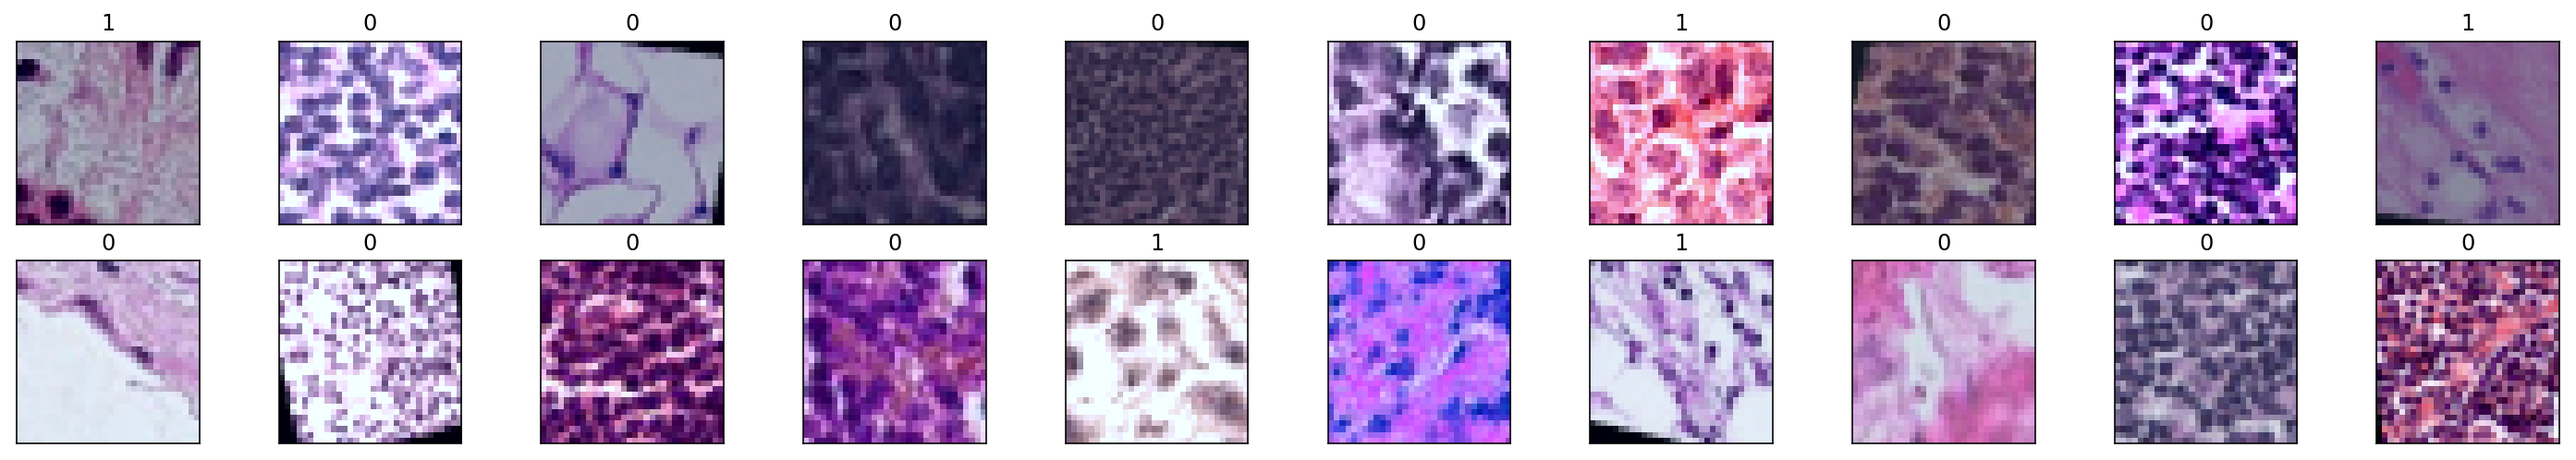

In [15]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(labels[idx].item())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


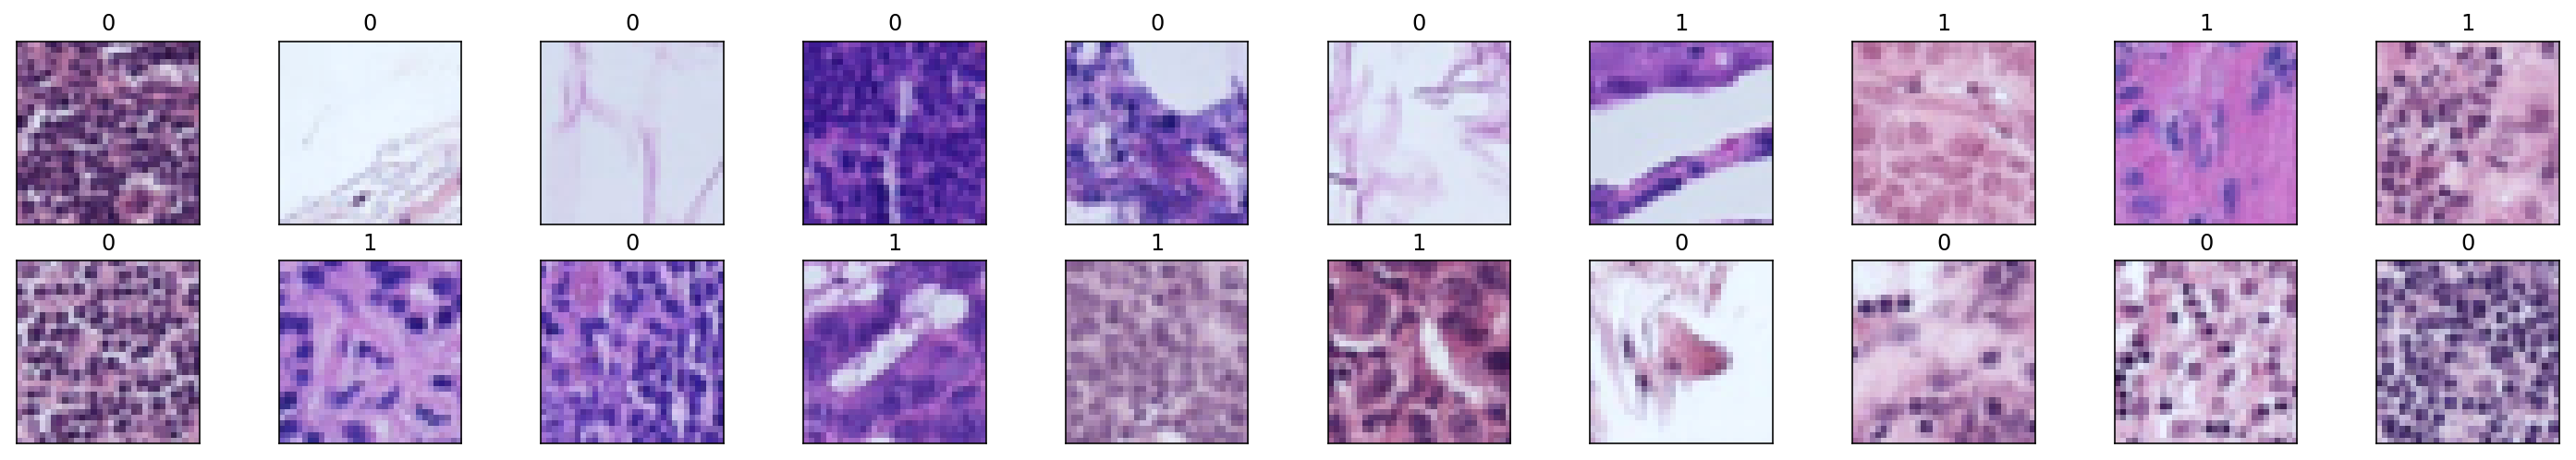

In [16]:
# obtain one batch of training images
dataiter = iter(valid_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(labels[idx].item())

##Time to define our CNN model

In [ ]:
# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layer
        self.conv1 = nn.Conv2d(3, 6, 3)
        self.conv2 = nn.Conv2d(6, 12, 3)
        self.conv3 = nn.Conv2d(12, 16, 2)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        #FC Layers
        self.hidden_1 = nn.Linear(64, 64)
        self.hidden_2 = nn.Linear(64, 32)
        self.hidden_3 = nn.Linear(32, 2)
        self.dropout = nn.Dropout(p=0.5)
        

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.shape[0], -1)
#        print(x.shape)
        x = F.relu(self.hidden_1(x))
        x = self.dropout(x)
        x = F.relu(self.hidden_2(x))
        x = self.dropout(x)
        x = F.log_softmax(self.hidden_3(x), dim=1)
        
        
        return x

# create a complete CNN
model = Net()
print(model)

##Add Optimizer and Loss finctions

In [ ]:
# specify loss function
criterion = nn.NLLLoss()

# specify optimizer
optimizer = optim.Adam(model.parameters(), lr=.00075)

#Training Loop

In [ ]:
# number of epochs to train the model
n_epochs = 25 # you may increase this number to train a final model

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model = model.to(device)
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        
        data, target = data.to(device), target.to(device)
        
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    with torch.no_grad():
        for data, target in valid_loader:
            # move tensors to GPU if CUDA is available
           
            data, target = data.cuda(), target.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'histo_cancer_model.pth')
        valid_loss_min = valid_loss